In [2]:
import pickle

with open('mini_langid_v2.pkl', 'rb') as f:
    langid = pickle.load(f)
    # todo: load a better model that discriminates not only against Russian, but against other langs as well. 
    
def get_langs(text):
    return dict(zip(langid.classes_, langid.predict_proba([text])[0]))

In [3]:
import fasttext
from collections import Counter

class LanguageDetector:
    def __init__(self, path="../langid/lid.323.bin"):
        self.model = fasttext.load_model(path)

    def predict_lang(self, text, k=10):
        text = text.replace('\n', '  ')
        langs, proba = self.model.predict(text, k=k)
        res = Counter(dict(zip([lang[9:] for lang in langs], proba)))
        if 'myv' not in res:
            res['myv'] = 0
        return res
    
LD = LanguageDetector()


def get_langs(text):
    res = LD.predict_lang(text, k=10)
    if 'myv' not in res:
        res['myv'] = 0
    return res

In [14]:
get_langs('привет')

Counter({'ru': 0.9943341016769409,
         'mk': 0.005204378627240658,
         'uz': 0.00014568031474482268,
         'mrj': 9.53822600422427e-05,
         'inh': 8.693097333889455e-05,
         'tg': 6.929703522473574e-05,
         'sr': 5.840857556904666e-05,
         'km': 3.921201641787775e-05,
         'got': 2.1354753698688e-05,
         'bg': 1.9813965991488658e-05,
         'myv': 0})

In [13]:
get_langs('пек вадря')

Counter({'myv': 0.741814911365509,
         'ru': 0.20231327414512634,
         'lez': 0.013512101024389267,
         'tg': 0.00760134682059288,
         'be': 0.007184292189776897,
         'mdf': 0.006488762330263853,
         'koi': 0.006209804210811853,
         'inh': 0.003615177236497402,
         'uk': 0.003397351363673806,
         'be-tarask': 0.0020105792209506035})

In [1]:
import requests
import random
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.auto import tqdm, trange
from heapdict import heapdict

In [9]:
def get_page(url, timeout=0.1):
    res = requests.get(url)
    if '<title>Wikimedia Error</title>' in res.text:
        time.sleep(timeout)
        return get_page(url, timeout=timeout*2)
    return res.text

In [10]:
base_url = 'https://wikisource.org/wiki/Main_Page/Эрзянь'
#base_url = 'https://wikisource.org/wiki/Пици-палакст/Вете_иетне_кадовсть_удалов'

In [11]:
downloaded_pages = dict()
urls_queue = heapdict()
urls_queue[base_url] = 0

In [18]:
max_irrelevance = 3  # 2 is too little; 5 is too much. 
min_lang_score = 0.3

* A problem: non-erzya author pages with relevant erzya links.
    * Solution: estimate irrelevance as the number of sequen non-erzya hops that lead to current page. 
    * Do not follow the links only if the irrelevance is very high (i.e. we are deep in the non-Erzya Internet). 
    * First follow the links with lowest irrelevance
    
Crawling with max_irrelevance=3 takes about 5 hours. 

In [20]:
for i in trange(1_000_000):
    if len(urls_queue) == 0:
        break
    url, irrelevance = urls_queue.popitem()
    print(irrelevance, url)
    html = requests.get(url).text
    downloaded_pages[url] = html
    soup = BeautifulSoup(html)
    content = soup.find('div', {'id': 'mw-content-text'})
    if not content:
        continue
    page_myv_score = get_langs(content.text)['myv']
    print(page_myv_score)

    for a in content.findAll('a'):
        if not a.has_attr('href'):
            # skip anchors
            continue
        if a['href'].startswith('http') and not a['href'].startswith('https://wikisource.org/wiki/'):
            # skip external links
            continue
        if a['href'].startswith('/wiki/File:'):
            continue
        if a['href'].startswith('#'):
            continue
        if a['href'].startswith('/wiki/Main_Page') or a.text[-4:] in {'(ps)', '(ur)'}:
            # skip other languages
            continue
        if a['href'].startswith('/wiki/Page:'):
            # skip book pages, because the content is duplicated
            continue
        if a['href'].startswith('/wiki/Special:'):
            continue
        if 'action=edit' in a['href']:
            continue
        if a['href'].startswith('irc'):
            continue
        
        if a['href'].startswith('https://wikisource.org/wiki/'):
            new_url = a['href']
        else:
            new_url = 'https://wikisource.org' + a['href']
        
        link_myv_score = get_langs(content.text)['myv']
        if max(link_myv_score, page_myv_score) < min_lang_score:
            new_irrelevance = irrelevance + 1
        else:
            new_irrelevance = 0
        
        if new_url not in downloaded_pages and new_irrelevance <= max_irrelevance:
            # set the irrelevance, (or update it, if it can be lowered)
            urls_queue[new_url] = min(new_irrelevance, urls_queue.get(new_url, new_irrelevance))

  0%|          | 0/1000000 [00:00<?, ?it/s]

3 https://wikisource.org/wiki/Category:1814_works
0
3 https://wikisource.org/wiki/Ein_Einwand_gegen_die_Relativtheorie_der_Elektrodynamik_und_seine_Beseitigung
0
3 https://wikisource.org/wiki/El_noster_Domm
0
3 https://wikisource.org/wiki/User_talk:Trijnstel
0
3 https://wikisource.org/wiki/Category:1838_works
0
3 https://wikisource.org/wiki/Category:1781_works
0
3 https://wikisource.org/wiki/Special:AbuseLog
0
3 https://wikisource.org/wiki/User:Sushant_savla
0
3 https://wikisource.org/wiki/User:Chelin
0
3 https://wikisource.org/wiki/%D0%9A%D0%BE%D0%BB%D1%85%D0%BE%D0%B7%D0%BE%D0%BD%D1%8C_%D1%8D%D1%80%D1%8F%D1%84/1932/15/1910-%D1%86%D0%B5_%D0%BA%D0%B8%D0%B7%D0%BE%D0%BD%D1%8C_%D0%BF%D1%80%D0%B8%D0%B7%D1%8B%D0%B2%D1%82%D1%8C_%D0%B8%D0%BD%D1%8C_%D1%86%D0%B5%D0%B1%D1%8F%D1%80%D1%8C%D1%81%D1%82%D0%B0_%D0%B9%D0%BE%D1%82%D0%B0%D1%84%D1%82%D0%BE%D0%BC%D0%B0%D0%BD%D1%86_%D0%B8%D0%BD%D0%BA%D1%81%D0%B0_1-%D1%86%D0%B5_%D0%B8_34-%D1%86%D0%B5_%D0%B4%D0%B8%D0%B2%D0%B8%D0%B7%D0%B8%D0%BE%D0%BD%D0%BD%D0%B

0
3 https://wikisource.org/wiki/L%CA%BC_tejoro_de_Cherz
0
3 https://wikisource.org/wiki/L%27_Orco_e_l%27_Tod%C3%ABsch
0
3 https://wikisource.org/w/index.php?title=File:Knaves_of_Diamonds.pdf&page=2
0
3 https://wikisource.org/wiki/Le_Fracl_da_Mir%C3%AD
0
3 https://wikisource.org/wiki/La_segra_d%27_Anterm%C3%ABia
0
3 https://wikisource.org/wiki/Doutz_brais_e_crits
0
3 https://wikisource.org/wiki/Canuto_Thorman
0
3 https://wikisource.org/wiki/Le_Spiun_da_Bornech
0
3 https://wikisource.org/wiki/Johann_Schmidt
0
3 https://wikisource.org/wiki/J._G._M._Reynders_Sr.
0
3 https://wikisource.org/wiki/V._Plocek
0
3 https://wikisource.org/wiki/Ferdinand_Nehls
0
3 https://wikisource.org/wiki/Georg_E._Meyer
0
3 https://wikisource.org/wiki/Author:Jakob_Laub
0
3 https://wikisource.org/wiki/%D0%A1%D0%B2%D1%8F%D1%89%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D0%B8%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F_%D0%92%D0%B5%D1%82%D1%85%D0%BE%D0%B3%D0%BE_%D0%B7%D0%B0%D0%B2%D0%B5%D1%82%D0%B0_(%D0%BC%D0%BE%D0%BA%D1%88%D0%B5%D0%BD%

0
3 https://wikisource.org/wiki/Author:%D0%9D%D3%99%D0%B6%D0%B8%D0%B1_%D0%90%D1%81%D0%B0%D0%BD%D0%B1%D0%B0%D0%B5%D0%B2
0
3 https://wikisource.org/wiki/Straszliwe_przygody
0
3 https://wikisource.org/wiki/%D0%91%D0%B5%D0%B7%D0%B1%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%9C._%D0%98._%D0%A1%D0%BE%D1%87%D0%B8%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F%D1%82_1-%D1%86%D0%B5_%D1%82%D0%BE%D0%BC%D1%81%D1%8C_(1939)/%D0%9C%D0%B0%D1%82%D0%BE%D0%B2%D1%81%D1%8C_%D0%BA%D1%8F%D0%B6%D0%B5%D1%86/%D0%90-%D1%83%D1%85-%D1%8D%D1%85
0.1608557105064392
3 https://wikisource.org/wiki/Author:Schamun_Mani
0
3 https://wikisource.org/wiki/Author:Alessandro_Manzoni
0
3 https://wikisource.org/wiki/Autor:L%C3%BCci_Papa
0
3 https://wikisource.org/wiki/Category:Early_modern_authors
0
3 https://wikisource.org/wiki/User:Praxidicae
0
3 https://wikisource.org/wiki/L%27inverno
0
3 https://wikisource.org/wiki/%D0%A1%D0%B2%D1%8F%D1%89%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D0%B8%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F_%D0%92%D0%B5%D1%82%D1%85%D0%BE%D0%B

0
3 https://wikisource.org/wiki/User_talk:Chelin
0
3 https://wikisource.org/wiki/Histoire_des_Alpes_-_Storia_delle_Alpi_-_Geschichte_der_Alpen_(2009)/10#131
0
3 https://wikisource.org/wiki/Author:Plinius_il_Giuven
0
3 https://wikisource.org/wiki/%D0%92%D0%B0%D0%BB%D0%B4%D0%B0_%D1%8F%D0%BD/1932/06/%D0%9C%D0%BE%D0%BA%D1%88%D1%8D%D1%80%D0%B7%D1%8F%D0%BD%D1%8C_%D0%92%D0%9A%D0%9F(%D0%B1)-%D0%BD%D1%8C_%D0%BE%D0%B1%D0%BA%D0%BE%D0%BC%D1%82%D1%8C_%D0%BF%D1%83%D1%82%D1%84%D0%BA%D1%81%D0%BE%D1%86_%D1%82%D1%83%D0%BD%D0%B4%D0%B0%D0%BD%D1%8C_%D0%B2%D0%B8%D0%B4%D0%B5%D0%BC%D0%B0_%D0%BA%D0%B0%D0%BC%D0%BF%D0%B0%D0%BD%D0%B8%D1%8F%D1%82%D0%B8_%D0%B0%D0%BD%D0%BE%D0%BA%D0%BB%D0%B0%D0%BC%D0%B0%D1%82%D1%8C_%D0%BA%D0%BE%D0%BB%D0%B3%D0%B0
0.005364630836993456
3 https://wikisource.org/wiki/Wikisource_talk:Language_domain_requests
0
3 https://wikisource.org/wiki/%D0%9F%D0%B0%D0%BA%D1%81%D1%8F%D1%82%D1%8C_%D0%BC%D0%BE%D1%80%D0%B0%D1%81%D0%B0%D0%BD/%D0%A3%D0%BB%D1%8C%D1%85%D1%82%D1%8F%D0%BC%D0%B0_%D1%83%D0%B4%D0%B

0
3 https://wikisource.org/wiki/Author:Matie_Ploner
0
3 https://wikisource.org/wiki/Atto_di_rispetto
0
3 https://wikisource.org/wiki/%D0%91%D0%B5%D0%B7%D0%B1%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%9C._%D0%98._%D0%A1%D0%BE%D1%87%D0%B8%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F%D1%82_1-%D1%86%D0%B5_%D1%82%D0%BE%D0%BC%D1%81%D1%8C_(1939)/%D0%9A%D0%BE%D0%BB%D0%BC%D0%B0_%D0%BF%D0%B8%D0%BD%D0%BA%D1%82,_%D0%B8%D0%BB%D0%B8_%D0%BA%D0%BE%D0%BB%D0%BC%D0%B0_%D0%BC%D0%BE%D1%80%D0%BE%D1%82
0.0855276957154274
3 https://wikisource.org/wiki/%D0%91%D0%B5%D0%B7%D0%B1%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%9C._%D0%98._%D0%A1%D0%BE%D1%87%D0%B8%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F%D1%82_1-%D1%86%D0%B5_%D1%82%D0%BE%D0%BC%D1%81%D1%8C_(1939)/%D0%9B%D1%83%D0%B3%D0%B0_%D0%BB%D0%B0%D0%BD%D0%B3%D1%81%D0%B0
0.017967481166124344
3 https://wikisource.org/wiki/Author:Kapi%CA%BBolani
0
3 https://wikisource.org/wiki/Author:John_James_O%27Carroll
0
3 https://wikisource.org/wiki/%D0%A2%D0%BE%D1%80%D0%BC%D0%BE%D1%88_%D0%B1%D0%B0%D2%AB%D2%A1%

0.013454172760248184
3 https://wikisource.org/wiki/Cons%C3%A8j_daa_a_on_malcontent
0
3 https://wikisource.org/wiki/%E1%80%92%E1%80%B1%E1%80%AB%E1%80%80%E1%80%BA%E1%80%90%E1%80%AC%E1%80%85%E1%80%84%E1%80%BA%E1%80%9E%E1%80%AE%E1%80%9A%E1%80%AC%E1%80%99%E1%80%B1%E1%80%AC%E1%80%84%E1%80%BA%E1%80%9E%E1%80%AD%E1%80%AF%E1%80%B7%E1%80%99%E1%80%9F%E1%80%AF%E1%80%90%E1%80%BA%E1%80%A1%E1%80%9B%E1%80%AD%E1%80%95%E1%80%BA%E1%80%80%E1%80%B1%E1%80%AC%E1%80%84%E1%80%BA%E1%80%B8%E1%80%9E%E1%80%B1%E1%80%AC%E1%80%9E%E1%80%85%E1%80%BA%E1%80%95%E1%80%84%E1%80%BA%E1%80%90%E1%80%95%E1%80%84%E1%80%BA
0
3 https://wikisource.org/wiki/Anton_Colling
0
3 https://wikisource.org/wiki/User_talk:%D0%95%D1%80%D0%B4%D0%B5%D0%BD_%D0%9A%D0%B0%D1%80%D1%81%D1%8B%D0%B1%D0%B5%D0%BA%D0%BE%D0%B2
0
3 https://wikisource.org/wiki/S%C3%A9adna/28
0
3 https://wikisource.org/wiki/%D0%92%D0%B0%D0%BB%D0%B4%D0%B0_%D1%8F%D0%BD/1932/09-10/%D0%A1%D0%BE%D1%86%D0%B8%D0%B0%D0%BB%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9_%D1%8

0
3 https://wikisource.org/wiki/User:Alex_brollo
0
3 https://wikisource.org/wiki/%D0%92%D0%B0%D0%BB%D0%B4%D0%B0_%D1%8F%D0%BD/1929/02/%D0%9A%D0%BE%D0%BC%D0%BC%D1%83%D0%BD%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D0%B9_%D0%98%D0%BD%D1%82%D0%B5%D1%80%D0%BD%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%81%D1%8C
0.01549605093896389
3 https://wikisource.org/wiki/Category:1826_births
0
3 https://wikisource.org/wiki/User_talk:Prosody
0
3 https://wikisource.org/wiki/Johann_Wolfgang_von_Goethe
0
3 https://wikisource.org/wiki/%D0%92%D0%B5%D0%BB%D1%8C%D1%85%D0%BE%D0%B7%D1%8F%D0%B9%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%B0%D0%B9_%D0%B0%D1%80%D1%82%D0%B5%D0%BB%D1%8C%D1%82%D1%8C_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%D0%BD%D0%B0%D0%B9_%D1%83%D1%81%D1%82%D0%B0%D0%B2%D0%BE%D1%86/5
0.07661201059818268
3 https://wikisource.org/wiki/User_talk:Shenme
0
3 https://wikisource.org/wiki/Wikisource:Copyright_policy#Copyright_violations
0
3 https://wikisource.org/wiki/%E1%81%81%E1%81%89%E1%81%87%E1%81%8

In [21]:
len(urls_queue)

0

In [22]:
len(downloaded_pages)

8085

In [377]:
import json

In [380]:
with open('other_sources/wikisource_myv_raw.json', 'w') as f:
    json.dump(downloaded_pages, f, ensure_ascii=False, indent=1)

# FILTER BY LANG

In [23]:
from urllib.parse import urlencode, quote_plus, unquote_plus

In [24]:
dp2 = {unquote_plus(k): v for k, v in downloaded_pages.items()}

* myv probability (if it is top lang)
    * bad: 18 20(?)
    * good: 98 72

In [367]:
url = random.choice(list(dp2.keys()))
print(url)
html = dp2[url]
soup = BeautifulSoup(html)
content = soup.find('div', {'id': 'mw-content-text'})
langs = get_langs(content.text)
print(langs.most_common(3))

https://wikisource.org/wiki/Букине_марто_псакине_(ёвкс)
[('myv', 0.9460909366607666), ('mdf', 0.03701194003224373), ('udm', 0.005108405835926533)]


In [368]:
soup = BeautifulSoup(html)
content = soup.find('div', {'id': 'mw-content-text'})

for bad_tag in [
    ['sup'], ['style'], ['script'], 
    ['span', {'id': 'pr_page'}], 
    ['table', {'class': 'headertemplate'}], 
    ['table', {'class': 'licensetpl'}], 
    ['div', {'class': 'printfooter'}],
    ['div', {'id': 'ws-data'}],
    
]:
    for unwanted in content.find_all(*bad_tag):
        unwanted.extract()

In [369]:
print(content.text.count('і') / len(content.text.lower()))  # 0.005, 0.003 for bad texts, 0 for good ones
print(content.text.count('ѣ') / len(content.text.lower()))  # 0.001 for bad texts, 0 for good ones
print(content.text.count('ъ') / len(content.text.lower()))  # 0.025, for bad texts, 0.0004 for good ones

0.0
0.0
0.0


In [370]:
import re
text = re.sub('\n\n+', '\n\n', content.text).strip()
text = re.sub('\s*\[\d+\]\s*', ' ', text)
print(text)

Эрзянь ёвкст (скаскат). Пурныньзе М. Е. Евсевьев. СССР-энь Наротнэнь Центральной Издательствась. Москов, 1928

БУКИНЕ МАРТО ПСАКИНЕ.

Эрясть-айшть атят бабат кавонест. Ульнесь сынст уське пуло букинест, келей рога бараност, сивекс кирьга яксяргост, кичкере толга атякшост, кудо ваны псакинест.
Бабась мери атястень: „Атя, печкик букинесть, сывель пидитянок!”
Атясь човась пеель и лись кардайс букинень печкеме. Букине неизэ пеельсть и тусь ардозь вирев. Печкикскельсе атясь баранонь — баран-гак оргоць вирев. Оргоцть вирев яксяргост-как, атякшост-как. Кадовсть атят бабат сывельтеме. Эрясь, эрясь — псакинестак тусь вирев.
Эрить весе скотинаст вирьсэ. Сась сёксь. Псакине кармась кельмеме. Мольсь сон букиненень и мери: „Букине, а букине, давай кудо тейдянок, ато сы теле — кельмитянок.” Букине мери: „Давай! Адя ансяк бараноньгак терьцинек, седе курок кудось тееви.”
Мольсть бараннэнь и мерить: „Баран, а баран! адя мартонок кудонь тейме, теле сы кельмитянок!”
Баран мери: „монь понам покш, мон кудо

In [405]:
url2text = {}
for url, html in tqdm(dp2.items(), total=len(dp2)):
    soup = BeautifulSoup(html)
    content = soup.find('div', {'id': 'mw-content-text'})
    if not content:
        continue
    
    for bad_tag in [
        ['sup'], ['style'], ['script'], 
        ['span', {'id': 'pr_page'}], 
        ['table', {'class': 'headertemplate'}], 
        ['table', {'class': 'licensetpl'}], 
        ['div', {'class': 'printfooter'}],
        ['div', {'id': 'ws-data'}],

    ]:
        for unwanted in content.find_all(*bad_tag):
            unwanted.extract()
    text = re.sub('\n\n+', '\n\n', content.text).strip()
    text = re.sub('\s*\[\d+\]\s*', ' ', text).strip()
    if len(text) < 10:
        continue
        
    langs = get_langs(text)
    if langs.most_common(1)[0][0] != 'myv' or langs.get('myv', 0) < 0.2:
        continue
    
    if sum([
        content.text.count('і') / len(content.text.lower()) > 0.003, # 0.005, 0.003 for bad texts, 0 for good ones
        content.text.count('ѣ') / len(content.text.lower()) > 0.001, # 0.001 for bad texts, 0 for good ones
        content.text.count('ъ') / len(content.text.lower()) > 0.003, # 0.025, for bad texts, 0.0004 for good ones
    ]) >= 2:
        # and archaic style, skip it
        continue
    
        
    url2text[url] = text

  0%|          | 0/8085 [00:00<?, ?it/s]

In [406]:
len(url2text)

1167

In [407]:
with open('other_sources/wikisource_myv_clean.json', 'w') as f:
    json.dump(url2text, f, ensure_ascii=False, indent=1)

In [427]:
url = random.choice(list(url2text.keys()))
print(get_langs(url2text[url]).most_common(1))
print(url)
print(url2text[url])

[('myv', 0.9704858660697937)]
https://wikisource.org/wiki/Таго_казнеть!
Статья на сайте газеты: № 193, 24.09.2004, СПОРТ СПОРТ СПОРТ

 

Таго казнеть!

Московсо «Россия» концертной залсо сентябрянь 13-це чистэ пурнавкшнось Россиянь спортивной элитась. «Нефта Москва» нефтяной компаниясь казнесь казнесэ Олимпийской командань спортсментнэнь, кить Афинасо невтсть паро выступленият. Сынст ютксо зярыя спортсмент Мордовиястояк. Истя, Олимпийской чемпиононтень Алексей Мишиннэнь максозь ярмаконь премия, конань покшолмазо 100 тыщат американской долларт. Денис Нижегородовнень максозь 20 тыщат долларт. Истя жо максозь гимнастонтень Алексей Немовнень. Эште вейке минек земляконтень, Юрий Борзаковскийнень, максозь 50 тыщат. Весемез те чистэнть Московсо получасть казнеть 45 спортсмент. Сехте покш казнесь максозель укшныцятненень Анастасия Давыдованень ды Анастасия Ермакованень. Сынст казнень покшолмаст 120 тыщат американь долларт.


# Align the Soviet consitiution

In [3]:
import requests
from bs4 import BeautifulSoup
import re

In [8]:
html = requests.get('https://ru.wikisource.org/wiki/Конституция_СССР_(1936)/Редакция_21.08.1938').text

In [9]:
soup = BeautifulSoup(html)
content = soup.find('div', {'id': 'mw-content-text'})

for bad_tag in [
    ['sup'], ['style'], ['script'], 
    ['span', {'id': 'pr_page'}], 
    ['table', {'class': 'headertemplate'}], 
    ['table', {'class': 'licensetpl'}], 
    ['div', {'class': 'printfooter'}],
    ['div', {'id': 'ws-data'}],

]:
    for unwanted in content.find_all(*bad_tag):
        unwanted.extract()
text = re.sub('\n\n+', '\n\n', content.text).strip()
text = re.sub('\s*\[\d+\]\s*', ' ', text).strip()

In [19]:
ru_text_full = text

In [21]:
print(ru_text_full[:500])

См. также одноимённые страницы.Дата создания: 05.12.1936, редакция 21.08.1938, опубл.: 1938. Источник: Редакция от 15.01.1938 + Закон СССР от 21 августа 1938 года «Об изменении и дополнении статей 22 и 23 Конституции (Основного Закона) СССР» Википроекты:  Викитека  Википедия  Данные  Цитаты и афоризмы 

Документ приводится в следующей редакции:

Постановления Верховного Совета СССР от 15 января 1938 года «Об изменении и дополнении ст.ст. 22, 23, 26, 28, 29, 49, 77, 70, 78 и 83 Конституции (Основ


In [22]:
with open('other_sources/wikisource_myv_clean.json', 'r') as f:
    url2text = json.load(f)

In [28]:
myv_texts_full = []
for u in sorted(url2text.keys()):
    if 'Конституция' in u:
        print(u)
        myv_texts_full.append(url2text[u])
myv_text_full = '\n\n'.join(myv_texts_full)

https://wikisource.org/wiki/Советской_Социалистической_Республикатнень_Союзонь_Конституциясь
https://wikisource.org/wiki/Советской_Социалистической_Республикатнень_Союзонь_Конституциясь_(1936)
https://wikisource.org/wiki/Советской_Социалистической_Республикатнень_Союзонь_Конституциясь_(1936)/1938.01.15
https://wikisource.org/wiki/Советской_Социалистической_Республикатнень_Союзонь_Конституциясь_(1936)/1938.01.15/01
https://wikisource.org/wiki/Советской_Социалистической_Республикатнень_Союзонь_Конституциясь_(1936)/1938.01.15/02
https://wikisource.org/wiki/Советской_Социалистической_Республикатнень_Союзонь_Конституциясь_(1936)/1938.01.15/03
https://wikisource.org/wiki/Советской_Социалистической_Республикатнень_Союзонь_Конституциясь_(1936)/1938.01.15/04
https://wikisource.org/wiki/Советской_Социалистической_Республикатнень_Союзонь_Конституциясь_(1936)/1938.01.15/05
https://wikisource.org/wiki/Советской_Социалистической_Республикатнень_Союзонь_Конституциясь_(1936)/1938.01.15/06
https://wiki

In [31]:
print(len(myv_text_full), len(ru_text_full))

45791 40774


In [11]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from razdel import sentenize, tokenize
import json 
import re
import random
from tqdm.auto import tqdm, trange

In [12]:
import torch
from transformers import AutoTokenizer, AutoModel
mname = 'labse_erzya_v0'
tokenizer = AutoTokenizer.from_pretrained(mname)
model = AutoModel.from_pretrained(mname)

Some weights of the model checkpoint at labse_erzya_v0 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
model.cuda();

In [14]:
def embed(text):
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    with torch.inference_mode():
        model_output = model(**encoded_input.to(model.device))
    embeddings = model_output.pooler_output
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [15]:
def center_norm(v):
    v = v - v.mean(0)
    return v /  (v**2).sum(1, keepdims=True) ** 0.5


def center_dot(x, y):
    m = (x.sum(0) + y.sum(0)) / (x.shape[0] + y.shape[0])
    x = x - m
    y = y - m
    x =  x /  (x**2).sum(1, keepdims=True) ** 0.5
    y =  y /  (y**2).sum(1, keepdims=True) ** 0.5
    return np.dot(x, y.T)

In [16]:
def get_top_mean_by_row(x, k=5):
    m, n = x.shape
    k = min(k, n)
    topk_indices = np.argpartition(x, -k, axis=1)[:, -k:]
    rows, _ = np.indices((m, k))
    return x[rows, topk_indices].mean(1)

In [17]:
def align3(sims):
    
    #sims = np.dot(center_norm(orig_vecs), center_norm(sum_vecs).T) ** 3
    #sims = center_dot(orig_embeds, sum_embeds) #** 3

    rewards = np.zeros_like(sims)
    choices = np.zeros_like(sims).astype(int)  # 1: choose this pair, 2: decrease i, 3: decrease j

    # алгоритм, разрешающий пропускать сколько угодно пар, лишь бы была монотонность
    for i in range(sims.shape[0]):
        for j in range(0, sims.shape[1]):
            # вариант первый: выровнять i-тое предложение с j-тым
            score_add = sims[i, j]
            if i > 0 and j > 0:  # вот как тогда выровняются предыдущие 
                score_add += rewards[i-1, j-1]
                choices[i, j] = 1
            best = score_add
            if i > 0 and rewards[i-1, j] > best:
                best = rewards[i-1, j]
                choices[i, j] = 2
            if j > 0 and rewards[i, j-1] > best:
                best = rewards[i, j-1]
                choices[i, j] = 3
            rewards[i, j] = best
    alignment = []
    i = sims.shape[0] - 1
    j = sims.shape[1] - 1
    while i > 0 and j > 0:
        if choices[i, j] == 1:
            alignment.append([i, j])
            i -= 1
            j -= 1
        elif choices[i, j] == 2:
            i -= 1
        else:
            j -= 1
    return alignment[::-1]

In [33]:
import razdel

In [34]:
sents_er = [s.text for p in myv_text_full.split('\n') for s in razdel.sentenize(p)  if s.text]
sents_ru = [s.text for p in ru_text_full.split('\n') for s in razdel.sentenize(p)  if s.text]
print(len(sents_ru), len(sents_er))

507 551


In [36]:
emb_ru = np.stack([embed(s) for s in tqdm(sents_ru)])
emb_er = np.stack([embed(s) for s in tqdm(sents_er)])

  0%|          | 0/507 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

In [37]:
pen = np.array([[min(len(x), len(y)) / max(len(x), len(y)) for x in sents_er] for y in sents_ru])
sims = np.maximum(0, np.dot(emb_ru, emb_er.T)) ** 1 * pen

alpha = 0.2
penalty = 0.2
sims_rel = (sims.T - get_top_mean_by_row(sims) * alpha).T - get_top_mean_by_row(sims.T) * alpha - penalty

alignment = align3(sims_rel)

print(sum(sims[i, j] for i, j in alignment) / min(sims.shape))

0.6963204457993986


In [40]:
print(len(alignment))

453


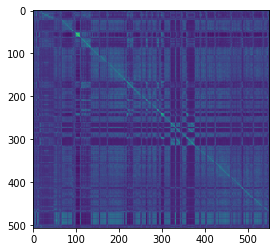

In [38]:
plt.imshow(sims_rel)

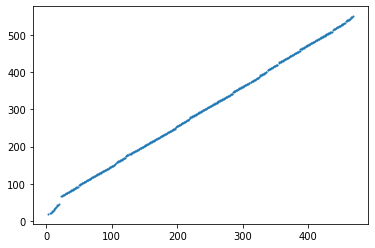

In [39]:
plt.scatter(*list(zip(*alignment)), s=1);

In [44]:
for i, j in alignment:
    print(sents_ru[i])
    print(sents_er[j])
    print(sims[i, j])
    print('-')

Постановления Верховного Совета СССР от 15 января 1938 года «Об изменении и дополнении ст.ст. 22, 23, 26, 28, 29, 49, 77, 70, 78 и 83 Конституции (Основного Закона) СССР», 29, 70, 78, 83, дополнены статьи 49 и 77
Советской Социалистической Республикатнень Союзонь Конституциянть (Основной Закононть) публикуемой текстэсь включает полавтомат ды дополненият, конатнень приминзе СССР-нь Верховной Советэнь 1-це сессиясь 1938 иень январень 15-це чистэ.
0.6150951649280304
-
КОНСТИТУЦИЯ (Основной Закон)Союза Советских Социалистических Республик
СОВЕТСКОЙ СОЦИАЛИСТИЧЕСКОЙ РЕСПУБЛИКАТНЕНЬ СОЮЗОНЬ КОНСТИТУЦИЯСЬ (ОСНОВНОЙ ЗАКОНОСЬ)
0.6162915130456289
-
1 Глава I  Общественное устройство
I ГЛАВАОбщественной устройствась
0.7591139849494485
-
2 Глава II  Государственное устройство
II ГЛАВАГосударственной устройствась
0.67540106647893
-
3 Глава III  Высшие органы государственной власти Союза Советских Социалистических Республик
III ГЛАВАСоветской Социалистической Республикатнень Союзонть государственной

In [49]:
constitution_pairs = []
for i, j in alignment:
    if re.match('Статья \d+\.$', sents_ru[i]):
        continue
    if sims[i, j] >= 0.45: 
        constitution_pairs.append([sents_er[j], sents_ru[i]])
for p in constitution_pairs:
    p[0] = p[0].replace('\xa0', ' ')
    p[1] = p[1].replace('\xa0', ' ')
print(len(constitution_pairs))

304


In [50]:
with open('other_sources/ussr_constitution_aligned.json', 'w') as f:
    json.dump(constitution_pairs, f, ensure_ascii=False)